In [2]:
library(tidyverse)
library(repr)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
#Preliminary Exploratory Data Analysis
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "data/Data_User_Modeling_Dataset_Hamdi.xls")

In [4]:
#Reads testing data
testing_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi.xls", sheet = 3) %>%
    select(STG:UNS) %>%
    mutate(UNS = as_factor(UNS))
head(testing_data, n = 10)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low
0.16,0.16,0.80,0.50,0.50,Middle
0.12,0.12,0.75,0.68,0.15,Low
0.20,0.20,0.88,0.77,0.80,High


In [5]:
#Reads training data
training_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = as_factor(UNS))
head(training_data, n = 10)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


In [6]:
#Counts observations for each type of UNS
observations_per_class <- training_data %>%
    group_by(UNS) %>%
    summarize("Count" = n())
observations_per_class

`summarise()` ungrouping output (override with `.groups` argument)



UNS,Count
<fct>,<int>
very_low,24
High,63
Low,83
Middle,88


In [7]:
#Calculates means of predictor variables
predictor_means <- training_data %>%
    select(STG:PEG) %>%
    map_df(mean)
predictor_means

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


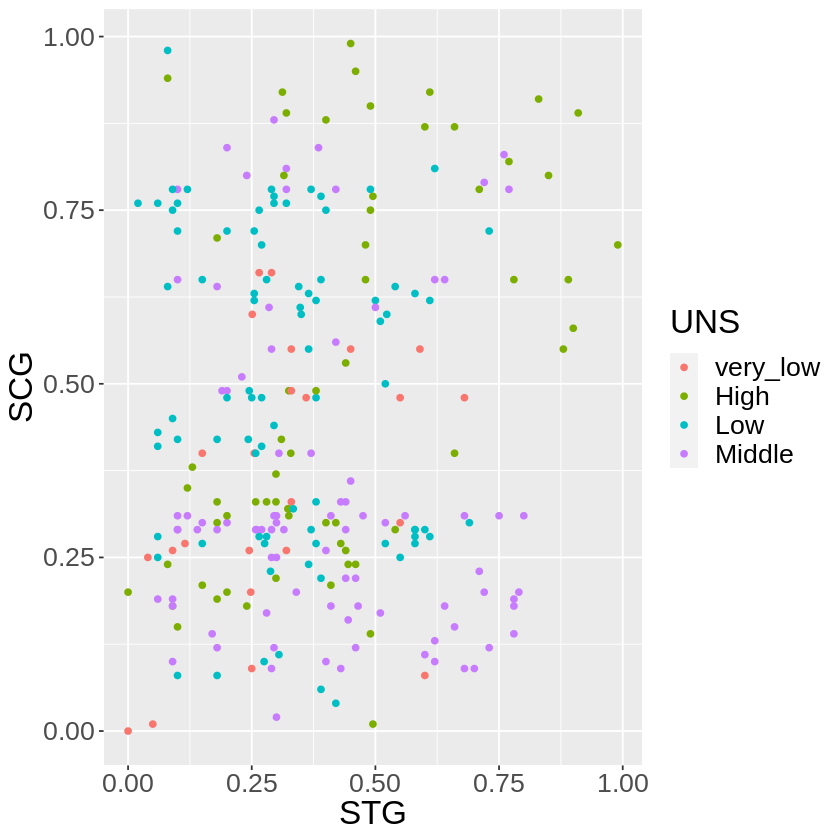

In [14]:
STG_vs_SCG <- ggplot(training_data, aes(x = STG, y = LPR, colour = UNS)) +
    geom_point() +
    labs(x = "STG", y = "SCG") +
    theme(text = element_text(size = 20))
STG_vs_SCG

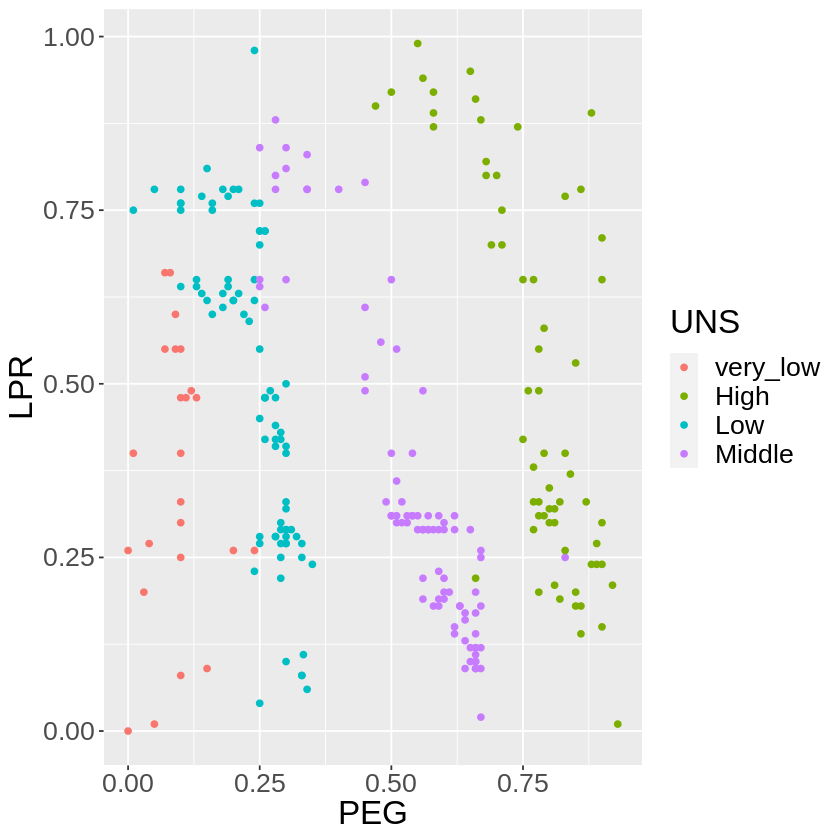

In [19]:
LPR_vs_PEG <- ggplot(training_data, aes(x = PEG, y = LPR, colour = UNS)) +
    geom_point() +
    theme(text = element_text(size = 20))
LPR_vs_PEG